<a href="https://colab.research.google.com/github/allanchia1-stack/CSCI218-Foundation-of-AI-Wine-Quality/blob/main/CSCI218_wine_group22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Number of duplicated rows: 937
After dropping duplicates: (3961, 12)

Missing values:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Summary statistics:
        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    3961.000000       3961.000000  3961.000000     3961.000000   
mean        6.839346          0.280538     0.334332        5.914819   
std         0.866860          0.103437     0.122446        4.861646   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.600000   
50%         6.800000          0.260000     0.320000        4.700000   
75%         7.300000          0.330000     0.390000        8.900000  

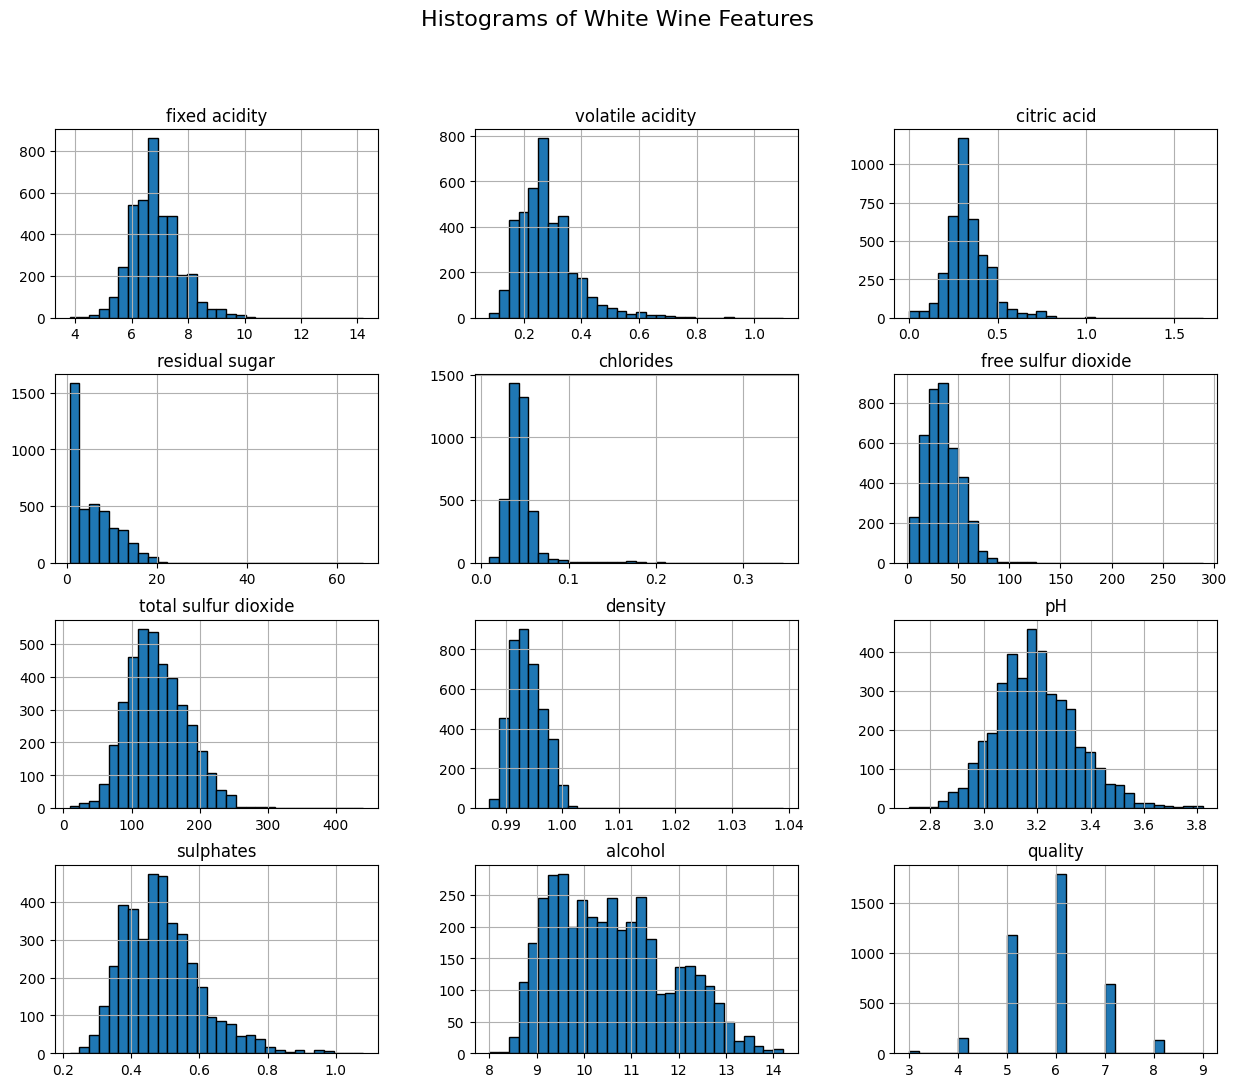

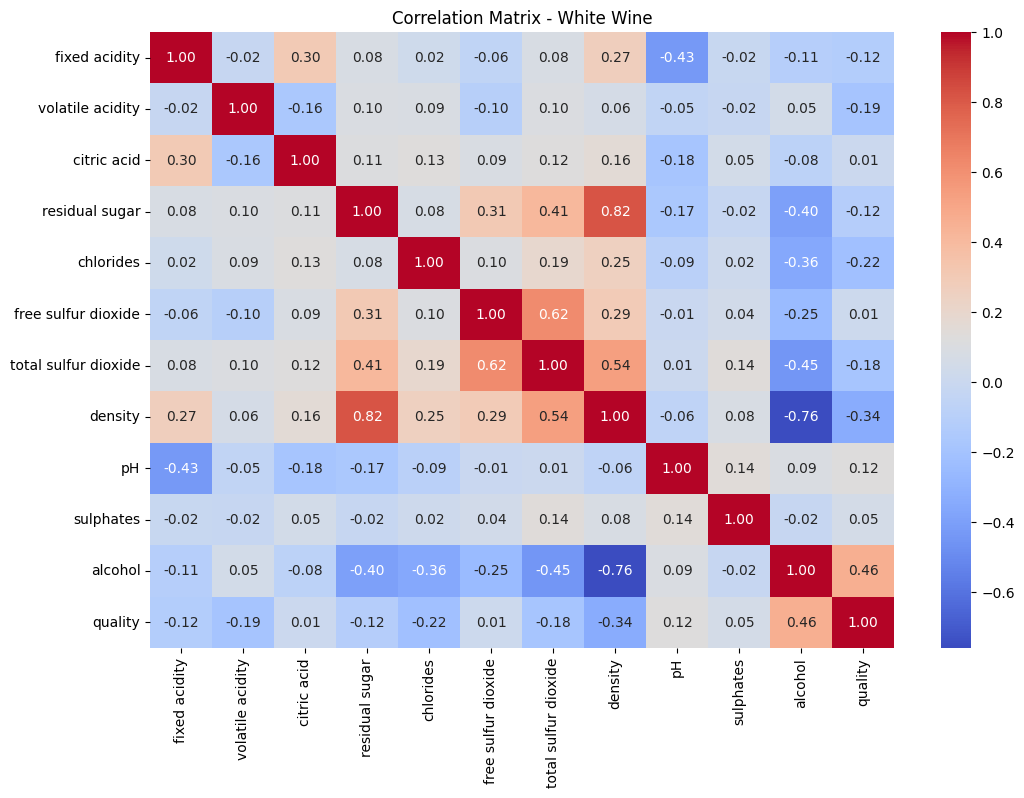


Grouped Distribution:
quality_group
1    2963
2     825
0     173
Name: count, dtype: int64
Class Weights: {np.int64(0): np.float64(7.6521739130434785), np.int64(1): np.float64(0.44556962025316454), np.int64(2): np.float64(1.6)}
===== WHITE WINE RESULTS =====

--- ORDINAL LOGISTIC REGRESSION ---
Accuracy: 0.6002522068095839
MAE: 0.4085750315258512
Confusion Matrix:
 [[ 17  14   4]
 [125 351 117]
 [  3  54 108]]
Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.49      0.19        35
           1       0.84      0.59      0.69       593
           2       0.47      0.65      0.55       165

    accuracy                           0.60       793
   macro avg       0.48      0.58      0.48       793
weighted avg       0.73      0.60      0.64       793


--- RANDOM FOREST ---
Accuracy: 0.7818411097099621
MAE: 0.21815889029003782
Confusion Matrix:
 [[  2  33   0]
 [  1 561  31]
 [  0 108  57]]
Classification Report:
              

In [6]:
# ============================================================
# Imports
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report

!pip install mord
import mord as m


# ============================================================
# Load Data
# ============================================================

whitewine = pd.read_csv(
    '/content/drive/My Drive/wine+quality/winequality-white.csv',
    sep=';'
)

white = whitewine.copy()


# ============================================================
# Data Cleaning
# ============================================================

print("Number of duplicated rows:", white.duplicated().sum())

white = white.drop_duplicates()
print("After dropping duplicates:", white.shape)

print("\nMissing values:\n", white.isnull().sum())
print("\nSummary statistics:\n", white.describe())


# ============================================================
# EDA
# ============================================================

white.hist(bins=30, figsize=(15, 12), edgecolor='black')
plt.suptitle("Histograms of White Wine Features", fontsize=16)
plt.show()

corr_white = white.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_white, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix - White Wine")
plt.show()


# ============================================================
# Group Quality: 3-4 Low, 5-6 Medium, 7-9 High
# ============================================================

def group_quality(q):
    if q <= 4:
        return 0   # Low
    elif q <= 6:
        return 1   # Medium
    else:
        return 2   # High

white["quality_group"] = white["quality"].apply(group_quality)

print("\nGrouped Distribution:")
print(white["quality_group"].value_counts())


# ============================================================
# Features & Target
# ============================================================

X = white.drop(["quality", "quality_group"], axis=1)
y = white["quality_group"]


# ============================================================
# Train-Test Split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# ============================================================
# Compute Class Weights (for OLR)
# ============================================================

classes = np.unique(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weight_dict)

sample_weights = y_train.map(class_weight_dict).values


# ============================================================
# Feature Scaling (for OLR)
# ============================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ============================================================
# Ordinal Logistic Regression
# ============================================================

olr = m.LogisticAT(alpha=1.0)

olr.fit(
    X_train_scaled,
    y_train,
    sample_weight=sample_weights
)

y_pred_olr = olr.predict(X_test_scaled)


# ============================================================
# Random Forest
# ============================================================

rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


# ============================================================
# Evaluation
# ============================================================

print("===== WHITE WINE RESULTS =====")

# --- OLR ---
print("\n--- ORDINAL LOGISTIC REGRESSION ---")
print("Accuracy:", accuracy_score(y_test, y_pred_olr))
print("MAE:", mean_absolute_error(y_test, y_pred_olr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_olr))
print("Classification Report:\n", classification_report(y_test, y_pred_olr))


# --- Random Forest ---
print("\n--- RANDOM FOREST ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Number of duplicated rows: 240
After dropping duplicates: (1359, 12)

Missing values:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Summary statistics:
        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1359.000000       1359.000000  1359.000000     1359.000000   
mean        8.310596          0.529478     0.272333        2.523400   
std         1.736990          0.183031     0.195537        1.352314   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.430000        2.600000  

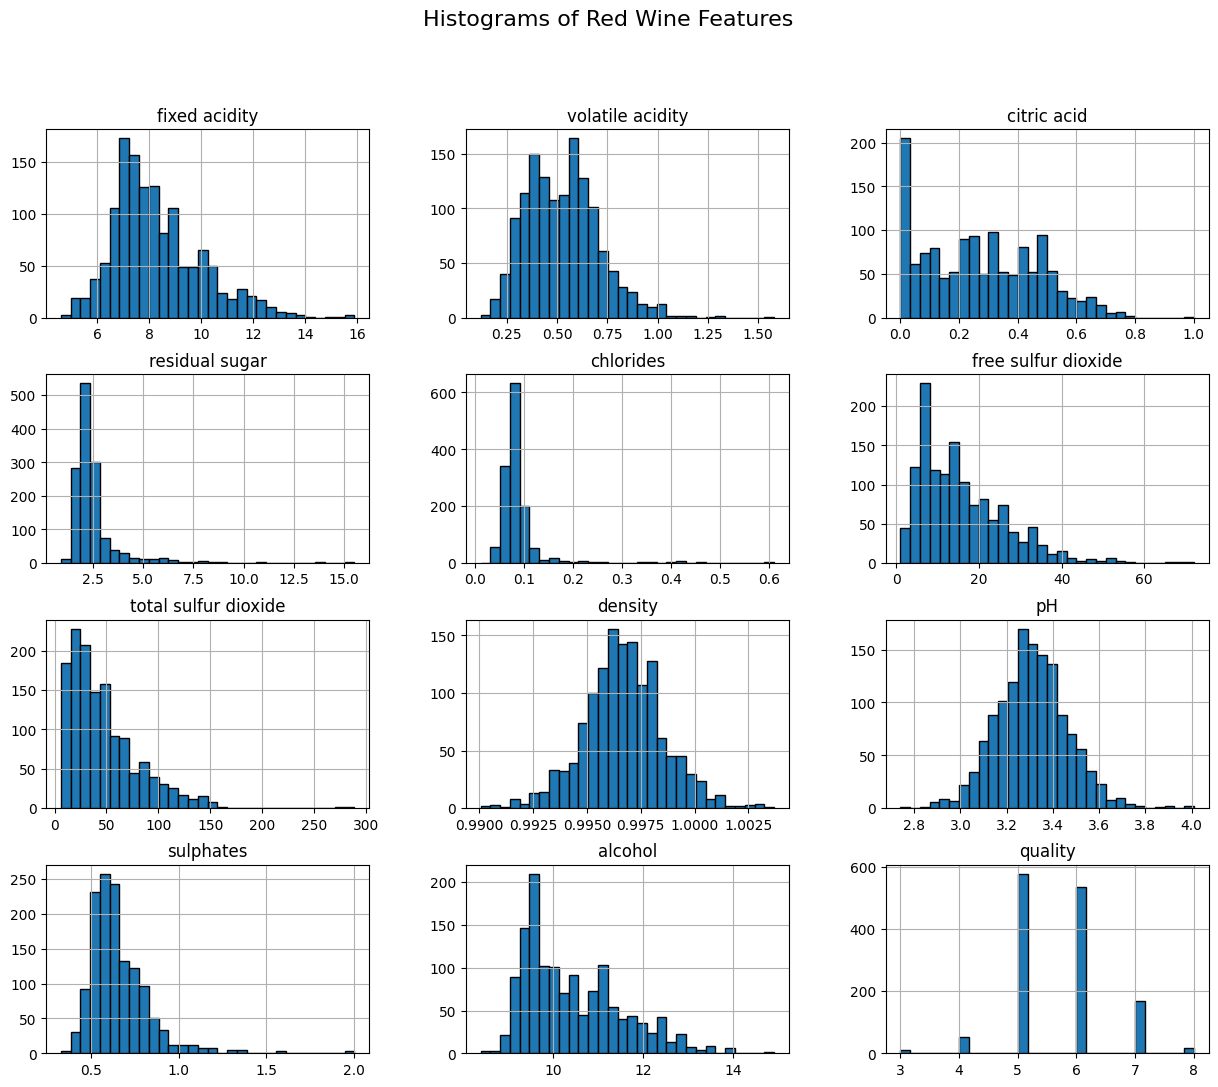

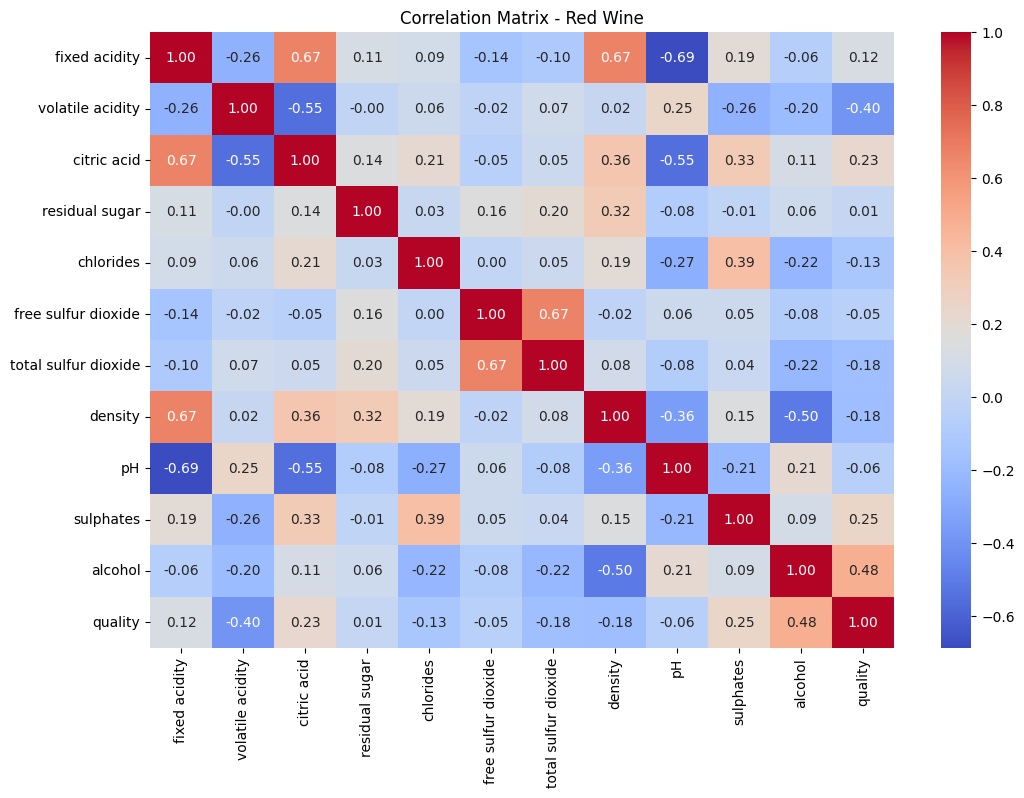


Grouped Distribution (Red Wine):
quality_group
1    1112
2     184
0      63
Name: count, dtype: int64
Class Weights (Red Wine): {np.int64(0): np.float64(7.246666666666667), np.int64(1): np.float64(0.40711610486891386), np.int64(2): np.float64(2.4648526077097506)}
===== RED WINE RESULTS =====

--- ORDINAL LOGISTIC REGRESSION ---
Accuracy: 0.5882352941176471
MAE: 0.41544117647058826
Confusion Matrix:
 [[  9   3   1]
 [ 54 121  47]
 [  0   7  30]]
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.69      0.24        13
           1       0.92      0.55      0.69       222
           2       0.38      0.81      0.52        37

    accuracy                           0.59       272
   macro avg       0.48      0.68      0.48       272
weighted avg       0.81      0.59      0.64       272


--- RANDOM FOREST ---
Accuracy: 0.8345588235294118
MAE: 0.16544117647058823
Confusion Matrix:
 [[  0  13   0]
 [  0 212  10]
 [  0  22  15]]
Cl

In [7]:
# ============================================================
# Load Data (Red Wine)
# ============================================================

redwine = pd.read_csv(
    '/content/drive/My Drive/wine+quality/winequality-red.csv',
    sep=';'
)

red = redwine.copy()


# ============================================================
# Data Cleaning
# ============================================================

print("Number of duplicated rows:", red.duplicated().sum())

red = red.drop_duplicates()
print("After dropping duplicates:", red.shape)

print("\nMissing values:\n", red.isnull().sum())
print("\nSummary statistics:\n", red.describe())


# ============================================================
# EDA
# ============================================================

red.hist(bins=30, figsize=(15, 12), edgecolor='black')
plt.suptitle("Histograms of Red Wine Features", fontsize=16)
plt.show()

corr_red = red.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_red, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix - Red Wine")
plt.show()


# ============================================================
# Group Quality: 3-4 Low, 5-6 Medium, 7-9 High
# ============================================================

def group_quality(q):
    if q <= 4:
        return 0   # Low
    elif q <= 6:
        return 1   # Medium
    else:
        return 2   # High

red["quality_group"] = red["quality"].apply(group_quality)

print("\nGrouped Distribution (Red Wine):")
print(red["quality_group"].value_counts())


# ============================================================
# Features & Target
# ============================================================

X = red.drop(["quality", "quality_group"], axis=1)
y = red["quality_group"]


# ============================================================
# Train-Test Split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# ============================================================
# Compute Class Weights (for OLR)
# ============================================================

classes = np.unique(y_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights (Red Wine):", class_weight_dict)

sample_weights = y_train.map(class_weight_dict).values


# ============================================================
# Feature Scaling (for OLR)
# ============================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ============================================================
# Ordinal Logistic Regression
# ============================================================

olr = m.LogisticAT(alpha=1.0)

olr.fit(
    X_train_scaled,
    y_train,
    sample_weight=sample_weights
)

y_pred_olr = olr.predict(X_test_scaled)


# ============================================================
# Random Forest
# ============================================================

rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


# ============================================================
# Evaluation
# ============================================================

print("===== RED WINE RESULTS =====")

# --- OLR ---
print("\n--- ORDINAL LOGISTIC REGRESSION ---")
print("Accuracy:", accuracy_score(y_test, y_pred_olr))
print("MAE:", mean_absolute_error(y_test, y_pred_olr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_olr))
print("Classification Report:\n", classification_report(y_test, y_pred_olr))


# --- Random Forest ---
print("\n--- RANDOM FOREST ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))
